In [6]:
try:
    output_filepath
except:
    output_filepath = 's3://workspaces-clarity-mgmt-pro/jaime.oliver/misc/social_capital/data/processed/'
    
import os
from pathlib import Path

import pandas as pd
import numpy as np
import numpy.linalg as la
from scipy import stats

import patsy
import statsmodels.api as sm
from linearmodels import PanelOLS
from linearmodels import RandomEffects
from linearmodels.panel import PooledOLS, compare

from linearmodels import IV2SLS

import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
data_path = os.path.join(output_filepath, 'panel_data.parquet')
df_model = pd.read_parquet(data_path)

df_model = df_model[df_model.year.between(1995, 2016)]

centralities = ['hubs', 'authorities','pagerank', 'gfi', 'bridging', 'favor']
centralities = ['hubs', 'authorities', 'favor']
networks = ['financial', 'goods', 'human']

df_model.dropna(subset=['log_GFCF'], inplace=True)

df_model.eval('productivity = gdp*10**6/(wkn_population**0.3*GFCF**0.7)', inplace=True)
for c in [f'{n}_{c}' for c in centralities for n in networks] + ['productivity']:
    df_model[c] = df_model[c].map(lambda x: np.log1p(x*1.e8))

#df_model = df_model[df_model.wkn_population>1.e6]

all_terms_list = [f'{n}_{c}' for n in networks for c in centralities]
reduced_terms_list = all_terms_list.copy()
reduced_terms_list.remove('goods_favor')
reduced_terms_list.remove('financial_favor')

## Residuals model

In [13]:
f = f'log_gdp ~ log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
base_model_fe = PanelOLS(y,X, entity_effects=True, time_effects=True)
base_model_fe = base_model_fe.fit()

df_model['residual'] = base_model_fe.resids.values

## Residual explanation model

In [14]:
models = []

f = f'residual ~ 1'
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
base_model_fe = PanelOLS(y,X, entity_effects=True, time_effects=True)
base_model_fe = base_model_fe.fit()

models.append(base_model_fe)
    
for v in reduced_terms_list:

    f = f'residual ~ {v} + 1'
    y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
    base_model_fe = PanelOLS(y,X, entity_effects=True, time_effects=True)
    base_model_fe = base_model_fe.fit()
    
    models.append(base_model_fe)
    

c = compare(dict(zip(['base model'] + reduced_terms_list, models)), precision='pvalues', stars=True)
#print(c.summary.as_latex())
c.summary

,base model,financial_hubs,financial_authorities,goods_hubs,goods_authorities,human_hubs,human_authorities,human_favor
Dep. Variable,residual,residual,residual,residual,residual,residual,residual,residual
Estimator,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS
No. Observations,3413,3413,3413,3413,3413,3413,3413,3413
Cov. Est.,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted
R-squared,0.0000,0.1274,0.0223,0.0053,0.0219,0.0022,0.0003,0.0017
R-Squared (Within),0.0000,0.0126,-0.0079,-0.0007,-0.0302,0.0021,0.0003,0.0016
R-Squared (Between),0.0000,-6.534e+27,-2.202e+27,-2.357e+26,-2.107e+27,-2.153e+27,-1.295e+26,-8.645e+26
R-Squared (Overall),0.0000,-0.3555,-0.1354,-0.0145,-0.1539,-0.1207,-0.0069,-0.0456
F-statistic,,471.40,73.597,17.047,72.206,7.0013,0.8219,5.3586
P-value (F-stat),,0.0000,0.0000,0.0000,0.0000,0.0082,0.3647,0.0207


In [16]:
reduced_terms_regression = ' + '.join(reduced_terms_list)

# Extended model
f = f'residual ~ {reduced_terms_regression} + 1'
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
extended_model = PooledOLS(y,X)
extended_model = extended_model.fit()

f = f'residual ~ {reduced_terms_regression} + 1'
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
extended_model_re = RandomEffects(y,X)
extended_model_re = extended_model_re.fit()

f = f'residual ~ {reduced_terms_regression} + 1'
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
extended_model_fe = PanelOLS(y,X, entity_effects=True, time_effects=True)
extended_model_fe = extended_model_fe.fit()

c = compare({'Base Model Fixed Effects':base_model_fe,
             'Extended Model Random Effects':extended_model_re,
             'Extended Model Fixed Effects':extended_model_fe}, precision='pvalues', stars=True)
#print(c.summary.as_latex())
c.summary

,Base Model Fixed Effects,Extended Model Random Effects,Extended Model Fixed Effects
Dep. Variable,residual,residual,residual
Estimator,PanelOLS,RandomEffects,PanelOLS
No. Observations,3413,3413,3413
Cov. Est.,Unadjusted,Unadjusted,Unadjusted
R-squared,0.0017,0.1005,0.2331
R-Squared (Within),0.0016,0.1436,0.1892
R-Squared (Between),-8.645e+26,-7.605e+26,-1.082e+28
R-Squared (Overall),-0.0456,0.1005,-0.4125
F-statistic,5.3586,54.321,139.91
P-value (F-stat),0.0207,0.0000,0.0000


In [17]:
def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    df = b[np.abs(b) < 1.e8].size
    chi2 = np.dot((b - B).T, la.inv(v_b - v_B).dot(b - B)) 

    pval = stats.chi2.sf(chi2, df)
    return chi2, df, pval

hausman_results = hausman(extended_model_fe, extended_model_re) 
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: 610.0888216381707
degrees of freedom: 8
p-Value: 1.585300853587165e-126


## Lasso

In [19]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'alpha': np.arange(0.1,0.9,0.1), 
   'l1_ratio': np.arange(0.1,0.9,0.1),
   'fit_intercept':[True],
   'normalize': [True],
   'selection':['cyclic', 'random'],
   'max_iter':[10000]}]


X = df_model[reduced_terms_list].values
y = df_model[['residual']].values

reg = GridSearchCV(
        ElasticNet(), param_grid)
reg.fit(X, y)
    

print(reg.best_estimator_.alpha)

print(reg.best_estimator_.intercept_)

pd.DataFrame({'variable':reduced_terms_list, 
              'coefficient':reg.best_estimator_.coef_}).sort_values(by='coefficient', ascending=False)

0.1
[-1.51851706e-14]


,variable,coefficient
0,financial_hubs,-0.0
1,financial_authorities,-0.0
2,goods_hubs,0.0
3,goods_authorities,0.0
4,human_hubs,0.0
5,human_authorities,0.0
6,human_favor,-0.0


## PCA

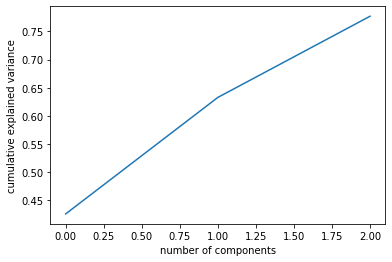

Dep. Variable:,residual,R-squared:,0.0140
Estimator:,PanelOLS,R-squared (Between):,-1.654e+26
No. Observations:,3413,R-squared (Within):,0.0234
Date:,"Mon, Aug 30 2021",R-squared (Overall):,0.0140
Time:,10:20:48,Log-likelihood,-849.91
Cov. Estimator:,Unadjusted,,
,,F-statistic:,16.094
Entities:,163,P-value,0.0000
Avg Obs:,20.939,Distribution:,"F(3,3409)"
Min Obs:,4.0000,,
Max Obs:,22.000,F-statistic (robust):,16.094


In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

n = 3

## PCA ---------
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA(n_components=n))]
        )

all_terms = reduced_terms_list.copy()
df_model[[f'pca_{i}' for i in range(n)]] = pipe.fit_transform(df_model[all_terms])

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA(n_components=n))]
        )
pipe.fit(df_model[all_terms])

plt.plot(np.cumsum(pipe['reduce_dims'].explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

## regression ---------
f = 'residual ~ 1 + ' + ' + '.join([f'pca_{i}' for i in range(n)])
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')

model = PanelOLS(y,X, entity_effects=True, time_effects=True)
model = RandomEffects(y,X)
model = PanelOLS(y,X)
results = model.fit()
results.summary

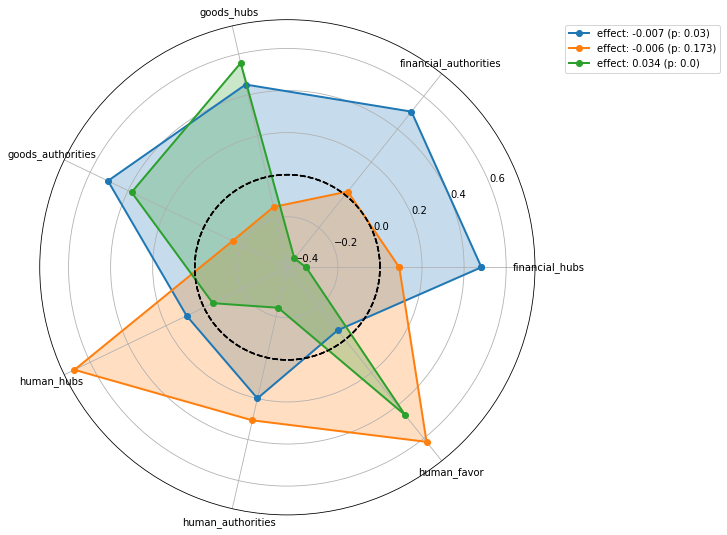

In [28]:
df_radar = pd.DataFrame(pipe['reduce_dims'].components_, columns = all_terms)
df_radar.loc[:,'coefs'] = pd.Series(results.params[[f'pca_{i}' for i in range(n)]].values)
df_radar['pvalues'] = pd.Series(results.pvalues[[f'pca_{i}' for i in range(n)]].values)

labels = all_terms.copy()
stats = pipe['reduce_dims'].components_[0]

angles=np.linspace(0, 2*np.pi, len(all_terms), endpoint=False)
circle_angles = np.linspace(0, 2*np.pi, 1000, endpoint=True)

fig=plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, polar=True)

for i in range(n):
    stats = df_radar.loc[i,all_terms]
    c = round(df_radar.loc[i,'coefs'], 3)
    p =  round(df_radar.loc[i,'pvalues'], 3)
    ax.plot(np.concatenate((angles,[angles[0]])), np.concatenate((stats,[stats[0]])), 
            'o-', 
            linewidth=2, 
            label = f'effect: {c} (p: {p})'
    )
    ax.fill(angles, stats, alpha=0.25)
    ax.plot(circle_angles, np.zeros_like(circle_angles), 'k--')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_thetagrids(angles * 180/np.pi, labels)
ax.grid(True)

plt.tight_layout()
save_to = os.path.join(Path(os.getcwd()).parent.resolve(), 'reports', 'figures', f'pca_results.png')
plt.savefig(save_to)    
plt.show()